# Gradient Examination - Main Quest

Trying to get a better idea of what our gradients "should" look like.

## Imports

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels

## Set Device to GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [3]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [4]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an image

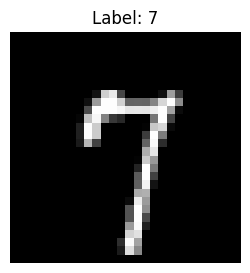

In [5]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [6]:
horizontal_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0 , 0],
    [ 1,  1,  1],
])

In [7]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

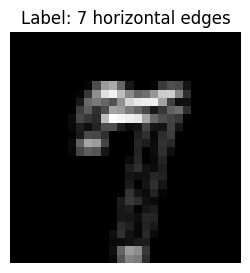

In [8]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [9]:
train_horizontal_image_labels = generate_intermediate_edge_labels(train_images, horizontal_kernel)

In [10]:
val_horizontal_image_labels = generate_intermediate_edge_labels(val_images, horizontal_kernel)

In [11]:
test_horizontal_image_labels = generate_intermediate_edge_labels(test_images, horizontal_kernel)

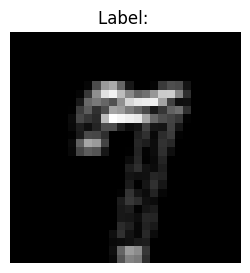

In [12]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [13]:
vertical_kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

In [14]:
vertical_edges = get_edges(vertical_kernel, sample_image)

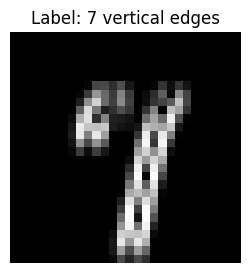

In [15]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [16]:
train_vertical_image_labels = generate_intermediate_edge_labels(train_images, vertical_kernel)

In [17]:
val_vertical_image_labels = generate_intermediate_edge_labels(val_images, vertical_kernel)

In [18]:
test_vertical_image_labels = generate_intermediate_edge_labels(test_images, vertical_kernel)

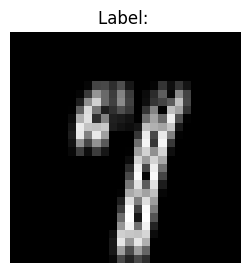

In [19]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

# Our Test

## Architecture

We keep our two hidden layers at image size to be able to calculate a local loss to push those layers to learn human recognizable structures. However, for the example below, we don't calculate intermediate loss, as we need a basis.

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal layer
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical layer connected to horizontal layer
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # coupling layer
        classification_out = self.classification_layer(vertical_act)
        
        return classification_out, vertical_act, horizontal_act

In [21]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [22]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [23]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [24]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [25]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx].copy()).float(),
            torch.from_numpy(self.vertical_edges[idx].copy()).float(),
        )

In [26]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [27]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

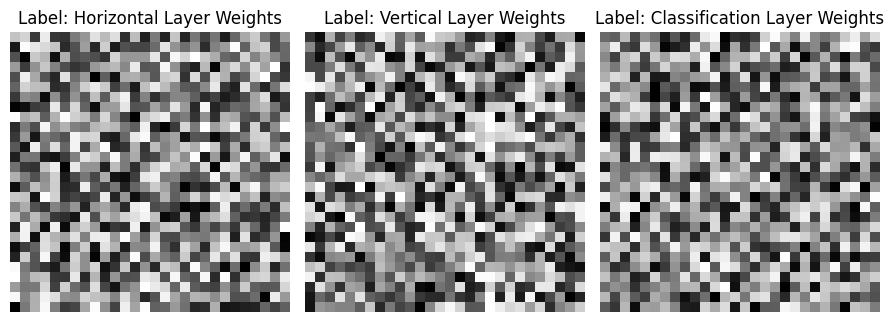

Epoch 1/20
  Train Loss: 0.4910
  Horizontal Edge Loss: 5.5890
  Vertical Edge Loss: 5.2637
  Val Loss: 0.1618 | Val Acc: 95.14%


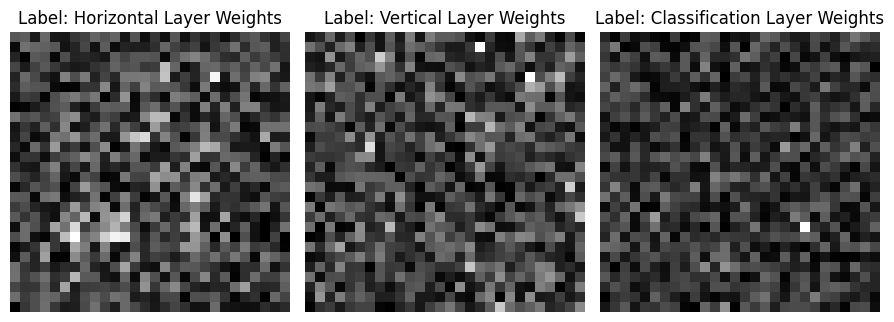

Epoch 2/20
  Train Loss: 0.1376
  Horizontal Edge Loss: 5.4167
  Vertical Edge Loss: 5.6801
  Val Loss: 0.1809 | Val Acc: 95.13%


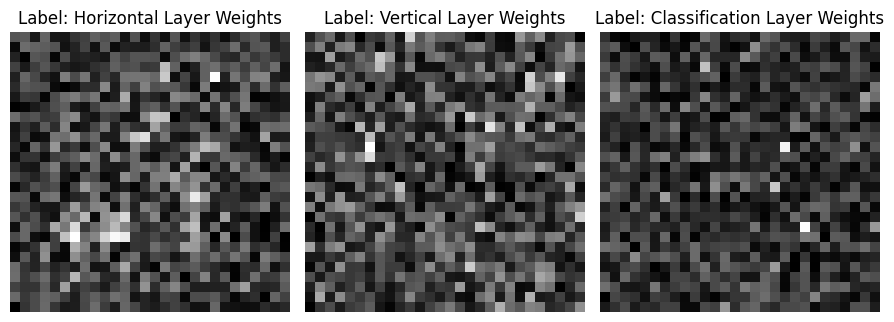

Epoch 3/20
  Train Loss: 0.1273
  Horizontal Edge Loss: 6.0522
  Vertical Edge Loss: 5.6561
  Val Loss: 0.1588 | Val Acc: 95.91%


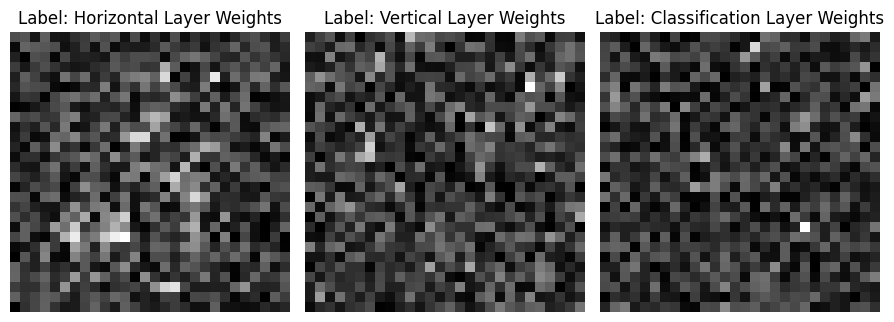

Epoch 4/20
  Train Loss: 0.1135
  Horizontal Edge Loss: 5.5571
  Vertical Edge Loss: 5.6668
  Val Loss: 0.1578 | Val Acc: 96.02%


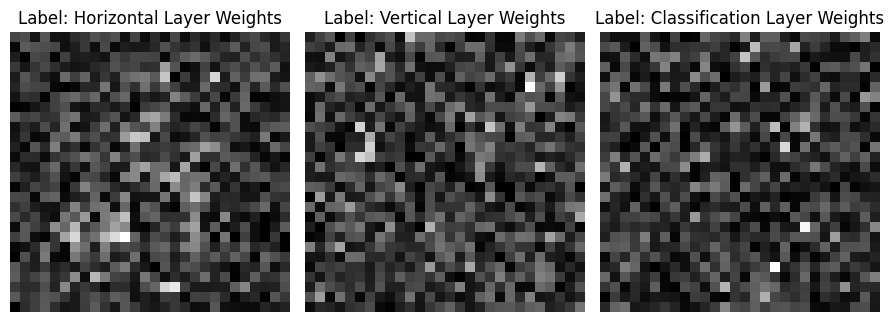

Epoch 5/20
  Train Loss: 0.1071
  Horizontal Edge Loss: 6.8220
  Vertical Edge Loss: 5.8327
  Val Loss: 0.2001 | Val Acc: 95.95%


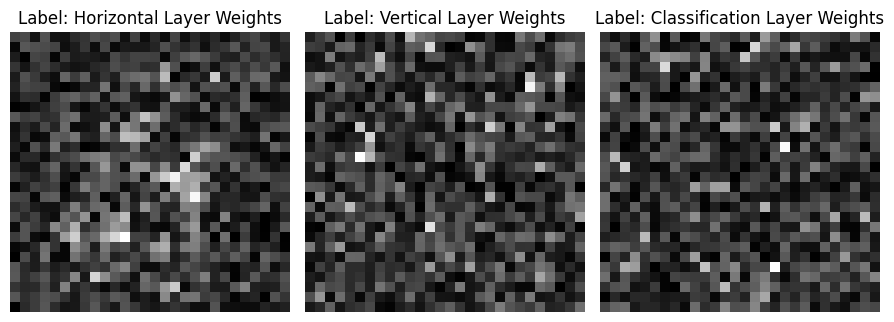

Epoch 6/20
  Train Loss: 0.1019
  Horizontal Edge Loss: 6.6694
  Vertical Edge Loss: 6.0035
  Val Loss: 0.1851 | Val Acc: 96.75%


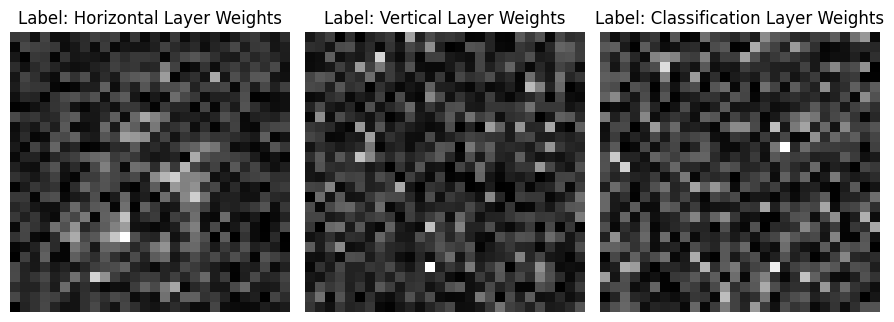

Epoch 7/20
  Train Loss: 0.1002
  Horizontal Edge Loss: 7.1122
  Vertical Edge Loss: 5.4407
  Val Loss: 0.1663 | Val Acc: 96.49%


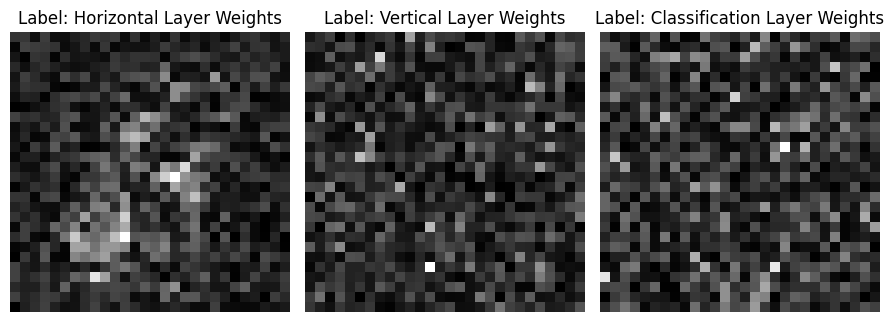

Epoch 8/20
  Train Loss: 0.0932
  Horizontal Edge Loss: 6.9617
  Vertical Edge Loss: 5.7145
  Val Loss: 0.1898 | Val Acc: 96.66%


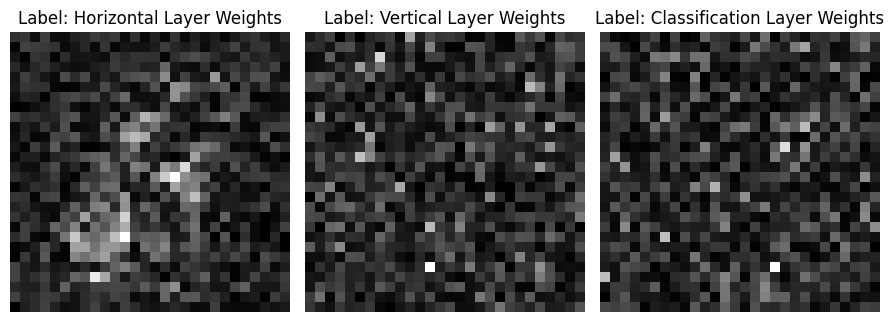

Epoch 9/20
  Train Loss: 0.0869
  Horizontal Edge Loss: 7.1309
  Vertical Edge Loss: 5.8033
  Val Loss: 0.2009 | Val Acc: 96.42%


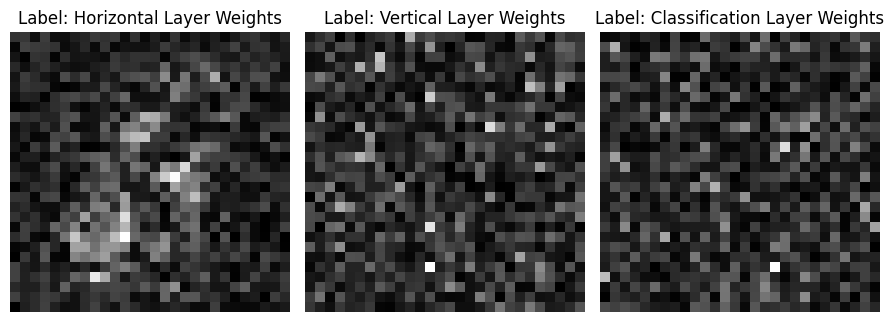

Epoch 10/20
  Train Loss: 0.0842
  Horizontal Edge Loss: 8.2345
  Vertical Edge Loss: 5.6458
  Val Loss: 0.2008 | Val Acc: 96.49%


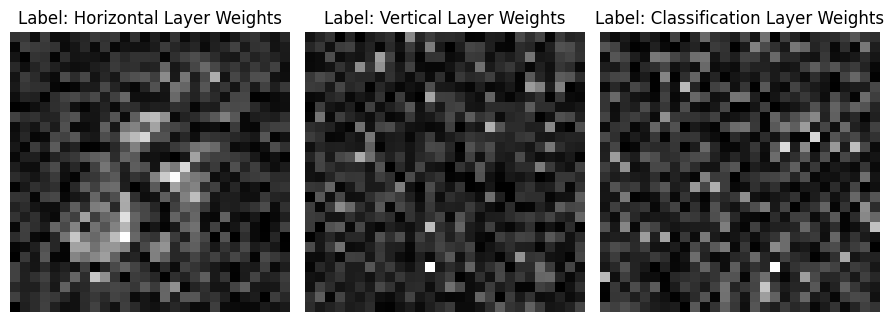

Epoch 11/20
  Train Loss: 0.0703
  Horizontal Edge Loss: 9.1875
  Vertical Edge Loss: 5.7121
  Val Loss: 0.1848 | Val Acc: 96.67%


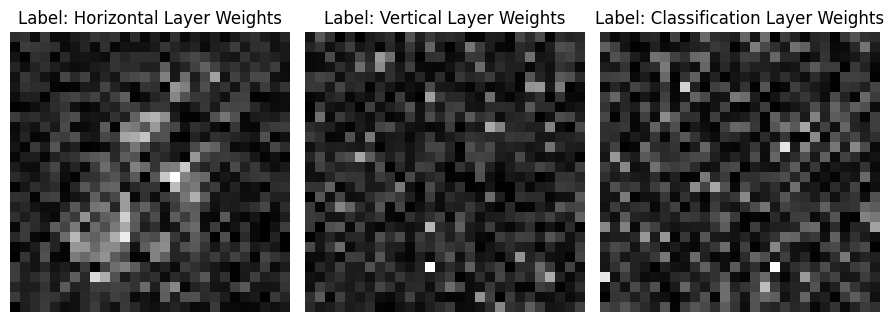

Epoch 12/20
  Train Loss: 0.0636
  Horizontal Edge Loss: 8.2536
  Vertical Edge Loss: 5.8957
  Val Loss: 0.2164 | Val Acc: 96.29%


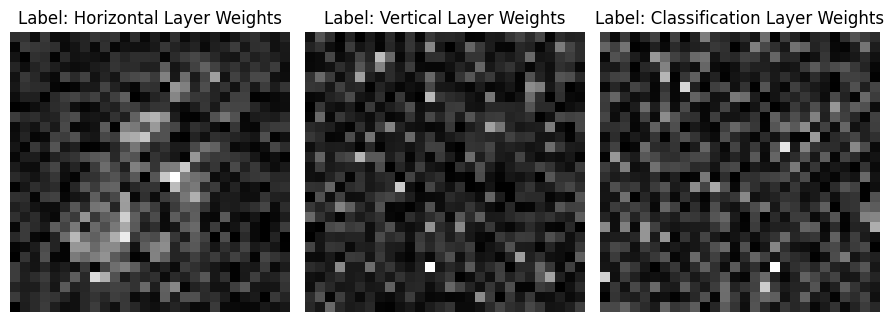

Epoch 13/20
  Train Loss: 0.0717
  Horizontal Edge Loss: 10.4040
  Vertical Edge Loss: 5.9185
  Val Loss: 0.1810 | Val Acc: 97.01%


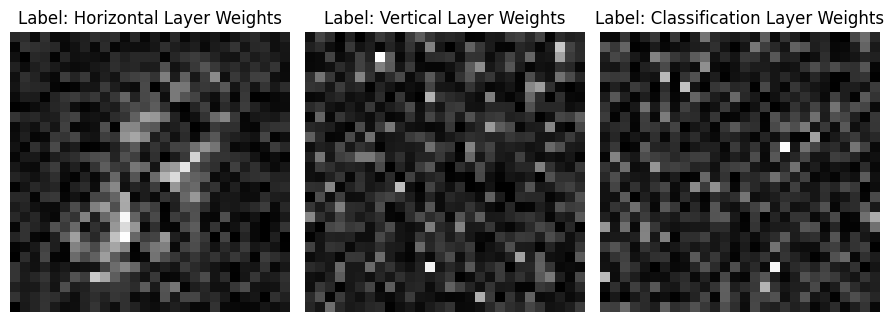

Epoch 14/20
  Train Loss: 0.0683
  Horizontal Edge Loss: 9.5017
  Vertical Edge Loss: 5.9934
  Val Loss: 0.3016 | Val Acc: 96.48%


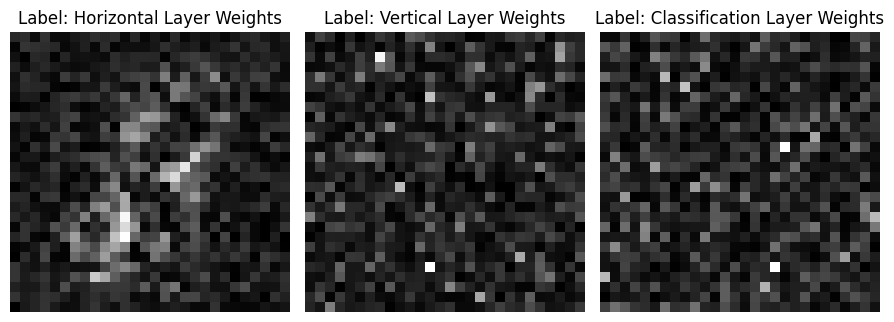

Epoch 15/20
  Train Loss: 0.0690
  Horizontal Edge Loss: 12.0106
  Vertical Edge Loss: 6.0547
  Val Loss: 0.2680 | Val Acc: 96.37%


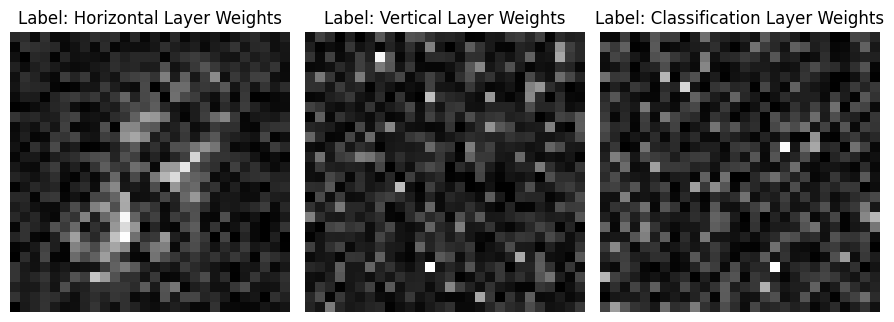

Epoch 16/20
  Train Loss: 0.0677
  Horizontal Edge Loss: 10.8901
  Vertical Edge Loss: 5.9797
  Val Loss: 0.2218 | Val Acc: 96.76%


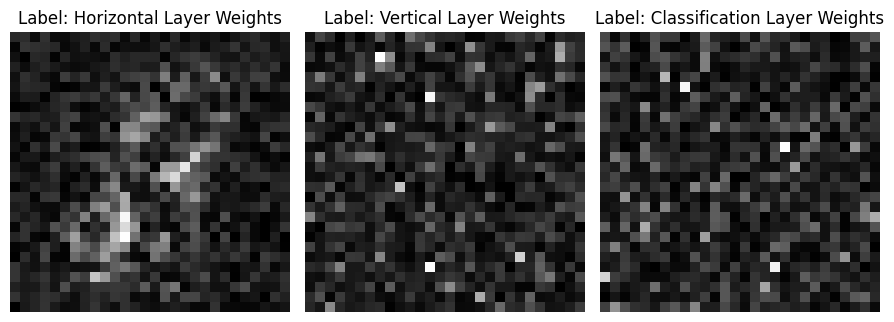

Epoch 17/20
  Train Loss: 0.0574
  Horizontal Edge Loss: 14.2095
  Vertical Edge Loss: 6.2514
  Val Loss: 0.2173 | Val Acc: 97.01%


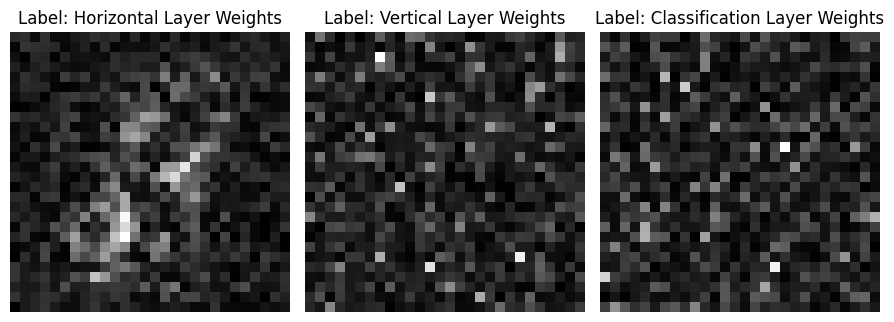

Epoch 18/20
  Train Loss: 0.0553
  Horizontal Edge Loss: 13.5814
  Vertical Edge Loss: 6.3625
  Val Loss: 0.2321 | Val Acc: 96.86%


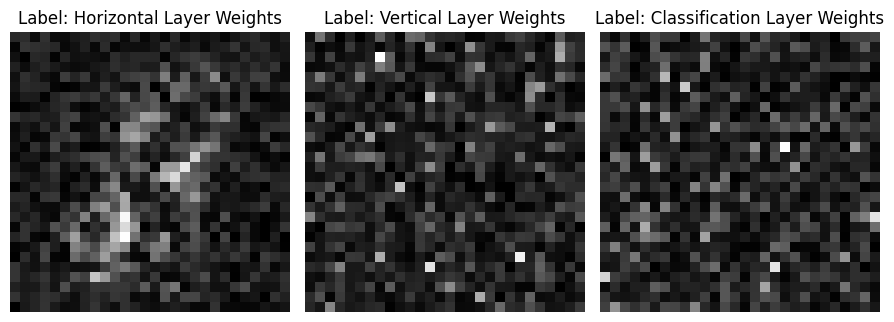

Epoch 19/20
  Train Loss: 0.0469
  Horizontal Edge Loss: 13.3021
  Vertical Edge Loss: 6.2445
  Val Loss: 0.2727 | Val Acc: 96.97%


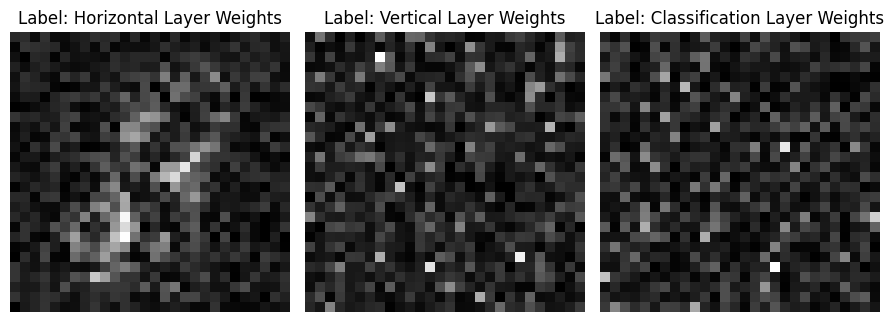

Epoch 20/20
  Train Loss: 0.0576
  Horizontal Edge Loss: 16.4650
  Vertical Edge Loss: 5.9686
  Val Loss: 0.3512 | Val Acc: 96.19%


In [28]:
num_epochs = 20
best_val_loss = float('inf')
gradient_dict = {}
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    # visualize weights at each layer during training
    classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    
    visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
    visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
    visualize_image(classification_w, "Classification Layer Weights", ax=axes[2])
    
    plt.tight_layout()
    plt.show()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels = batch
        images, labels, horizontal_labels, vertical_labels = images.to(device), labels.to(device), horizontal_labels.to(device), vertical_labels.to(device)
        
        # forward pass
        classification_out, vertical_act, horizontal_act = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # vertical loss
        vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)

        # horizontal loss
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = classification_loss
        total_loss.backward()

        # let's examine our gradients
        gradient_dict[epoch] = {
            "h_layer": [],
            "v_layer": [],
            "c_layer": [],
        }
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_to_save = param.grad.norm().item()
                if "horizontal_layer" in name:
                    gradient_dict[epoch]["h_layer"].append(grad_to_save)
                if "vertical_layer" in name:
                    gradient_dict[epoch]["v_layer"].append(grad_to_save)
                if "classification_layer" in name:
                    gradient_dict[epoch]["c_layer"].append(grad_to_save)
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    
    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_horizontal_loss = horizontal_loss / len(train_loader)
    avg_vertical_loss = vertical_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Horizontal Edge Loss: {avg_horizontal_loss:.4f}")
    print(f"  Vertical Edge Loss: {avg_vertical_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

## Examining Gradients

In [29]:
print("\t\tHorizontal Gradients\t\t\tVertical Gradients\t\t\t\tClassification Gradients")
for epoch in gradient_dict.keys():
    print(f"Epoch: {epoch + 1}:\t{gradient_dict[epoch]['h_layer']}  |  {gradient_dict[epoch]['v_layer']}  |  {gradient_dict[epoch]['c_layer']}")

		Horizontal Gradients			Vertical Gradients				Classification Gradients
Epoch: 1:	[1.2244640588760376, 0.0005301790661178529]  |  [0.9770914912223816, 0.0019290134077891707]  |  [1.2816544771194458, 0.014772182330489159]
Epoch: 2:	[7.043249130249023, 0.0034115046728402376]  |  [6.091741561889648, 0.01111673004925251]  |  [9.762289047241211, 0.07569349557161331]
Epoch: 3:	[18.30774688720703, 0.008216066285967827]  |  [14.943663597106934, 0.020048120990395546]  |  [25.95560073852539, 0.19078874588012695]
Epoch: 4:	[2.2058157920837402, 0.0011595466639846563]  |  [1.42498779296875, 0.0029774492140859365]  |  [1.3708223104476929, 0.025864362716674805]
Epoch: 5:	[9.946487426757812, 0.0046172840520739555]  |  [10.219937324523926, 0.012345409020781517]  |  [14.71264934539795, 0.08657673746347427]
Epoch: 6:	[5.356752872467041, 0.0021650746930390596]  |  [4.408950328826904, 0.005226693581789732]  |  [8.375381469726562, 0.04378116503357887]
Epoch: 7:	[0.027064960449934006, 1.2693587450485211e-05]

Not as bad as our partials case, but our gradients don't look so lovely here either. I see a fair bit of fluctuation. The good news is that this is more consistent across different layers.